# To visualize approaches

A simulated dataset is made to vizualize the filtering performed by the clustering approaches and the 

In [17]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_lr_filter as BE_LR_filter

from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


import pprint
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 11, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

figure_path = module_path + '/figures/lr_filter/'

def scatterplot_with_colors(X, y):
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
    colorsDict = {idx : color for (idx, color) in enumerate(colors)}
    colorsDict[-1] = '#484848'
    f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
    f.set_size_inches(5, 5)
    grouped = df.groupby('label')
    for key, group in grouped:
        label_key = key
        if key == -1:
            label_key = 'deleted samples'
        ax = group.plot(ax=ax, kind='scatter', x='x', y='y',
                        label=label_key, color=colorsDict[key] ,
                        s = 7, alpha=0.8)


    for label in ax.get_ylabel() :
        ax.set_ylabel(label, fontproperties = font)
    for label in ax.get_xlabel() :
        ax.set_xlabel(label, fontproperties = font)
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font)
    ax.legend(prop=font)
    
    return f

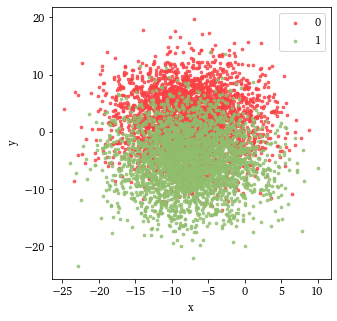

In [19]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=6000, centers=2, n_features=2, cluster_std = 5, random_state = 43)
# scatter plot, dots colored by class value

X, y = pd.DataFrame(X), pd.Series(y)

y = y.astype(int)
X.columns = np.arange(len(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

f = scatterplot_with_colors(X.values, y.values)

f.savefig(figure_path + 'simulated_dataset.pdf', bbox_inches='tight')

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

k_range = list(range(1,8))
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

thresh_list = [2,4,6]
folds_list = [5, 7, 10]


param_dict = BE_LR_filter.hyperparam_search(X_train,y_train, X_val, y_val, clf_dict, grid_dict = grid_dict, thresh_list = thresh_list, folds_list = folds_list)

pprint.pprint(param_dict)

{'knn': {'folds': 10, 'threshold': 2},
 'knnOptimal': {'folds': 10, 'threshold': 2},
 'nb': {'folds': 10, 'threshold': 2}}


In [20]:
dict_results, indices = BE_LR_filter.compare_classifiers(X_train,y_train, X_test, y_test, clf_dict, param_dict = param_dict)

pprint.pprint(dict_results)

{'knn': {'filtered': 0.8758782201405152, 'original': 0.6941666666666667},
 'knnOptimal': {'filtered': 0.896484375, 'original': 0.75},
 'nb': {'filtered': 0.8993963782696177, 'original': 0.7591666666666667}}


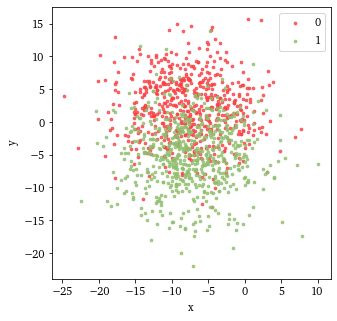

In [27]:
deleted=indices['knnOptimal']
mask=np.full(len(X_test),True,dtype=bool)
mask[deleted]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(X_test.values, y_test.values)

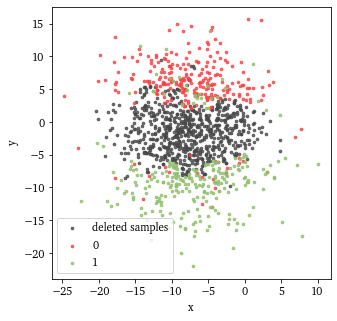

In [28]:
f = scatterplot_with_colors(X_test.values, new_y_test.values)
f.savefig(figure_path + 'simulated_data_LR_filtered.pdf', bbox_inches='tight')

# Adding noise

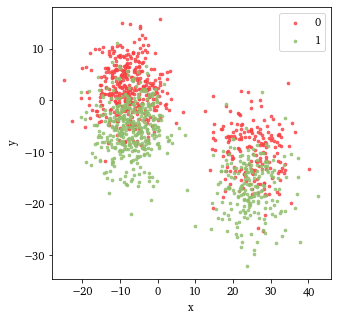

In [29]:
new_X, n_idx= BE_LR_filter.add_noise_dataset(X_test, 20, 3)
f = scatterplot_with_colors(new_X.values, y_test.values)

f.savefig(figure_path + 'simulated_data_with_noise_lr_not_filtered.pdf', bbox_inches='tight')

{'knn': {'filtered': 0.7007407407407408, 'original': 0.6591666666666667},
 'knnOptimal': {'filtered': 0.7192982456140351, 'original': 0.6891666666666667},
 'nb': {'filtered': 0.7133058984910837, 'original': 0.7}}


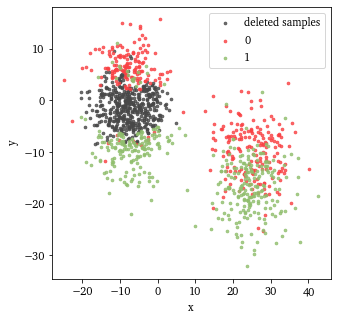

In [30]:
dict_results, indices = BE_LR_filter.compare_classifiers(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

deleted=indices['knnOptimal']
mask=np.full(len(new_X),True,dtype=bool)
mask[deleted]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1
f = scatterplot_with_colors(new_X.values, new_y_test.values)

pprint.pprint(dict_results)

f.savefig(figure_path + 'simulated_data_with_noise_lr_filtered.pdf', bbox_inches='tight')

Clearly this algorithm is not targeting the instances where noise in the data is the problem

# Gradually adding more noise and seeing the effect

Firstly gradually increasing the amplitude 

In [34]:
ampl_list = [5, 10, 15, 18, 22, 26]
result_dict = {}


for ampl in ampl_list:
    new_X, n_idx= BE_LR_filter.add_noise_dataset(X_test, ampl, 4)
    
    dict_results, indices = BE_LR_filter.compare_classifiers(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    result_dict[ampl] = dict_results
pprint.pprint(result_dict, depth = 3)

{5: {'knn': {'filtered': 0.8544303797468354, 'original': 0.6975},
     'knnOptimal': {'filtered': 0.8845470692717584,
                    'original': 0.7591666666666667},
     'nb': {'filtered': 0.885036496350365, 'original': 0.7641666666666667}},
 10: {'knn': {'filtered': 0.828719723183391, 'original': 0.7108333333333333},
      'knnOptimal': {'filtered': 0.8361669242658424, 'original': 0.745},
      'nb': {'filtered': 0.82398753894081, 'original': 0.75}},
 15: {'knn': {'filtered': 0.7833876221498371, 'original': 0.6933333333333334},
      'knnOptimal': {'filtered': 0.775, 'original': 0.7133333333333334},
      'nb': {'filtered': 0.7653213751868461, 'original': 0.7208333333333333}},
 18: {'knn': {'filtered': 0.751219512195122, 'original': 0.6766666666666666},
      'knnOptimal': {'filtered': 0.7609970674486803,
                     'original': 0.7066666666666667},
      'nb': {'filtered': 0.757847533632287, 'original': 0.7166666666666667}},
 22: {'knn': {'filtered': 0.7382113821138211

In [35]:
amount_list = [12, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
result_dict = {}


for am in amount_list:
    new_X, n_idx= BE_LR_filter.add_noise_dataset(X_test, 15, am)
    
    dict_results, indices = BE_LR_filter.compare_classifiers(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    result_dict[am] = dict_results
pprint.pprint(result_dict, depth = 3)

{2: {'knn': {'filtered': 0.7116104868913857, 'original': 0.6683333333333333},
     'knnOptimal': {'filtered': 0.6886016451233843,
                    'original': 0.6733333333333333},
     'nb': {'filtered': 0.6765402843601895, 'original': 0.6783333333333333}},
 3: {'knn': {'filtered': 0.755192878338279, 'original': 0.69},
     'knnOptimal': {'filtered': 0.7415426251691475,
                    'original': 0.7016666666666667},
     'nb': {'filtered': 0.7283950617283951, 'original': 0.7091666666666666}},
 4: {'knn': {'filtered': 0.7833876221498371, 'original': 0.6933333333333334},
     'knnOptimal': {'filtered': 0.775, 'original': 0.7133333333333334},
     'nb': {'filtered': 0.7653213751868461, 'original': 0.7208333333333333}},
 5: {'knn': {'filtered': 0.7917383820998278, 'original': 0.6908333333333333},
     'knnOptimal': {'filtered': 0.7935285053929122,
                    'original': 0.7233333333333334},
     'nb': {'filtered': 0.7861635220125787, 'original': 0.7275}},
 7: {'knn': {'fi